In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
from minisom import MiniSom
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib import colormaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
from itertools import product
import itertools
from sankeyflow import Sankey
from sammon import sammon
import igraph as ig
#import hexMinisom

In [2]:
dataset = xr.open_dataarray('data/Z500FiltAnoms_ERA5_v3.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(200, 310) #160W, 50W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

print(dataarray.shape)

(30681, 6771)


### User Metrics

In [3]:
def som_corr(som):
    weights = som.get_weights()
    neurons = list(product(range(weights.shape[0]), range(weights.shape[1])))
    wm = {neuron: [] for neuron in neurons}
    avgs = {neuron: [] for neuron in neurons}
    
    # sort the data into their winning neurons
    for i, x in enumerate(dataarray):
        wm[som.winner(x)].append(i)
        
    # calculate the average of each neuron
    for i in range(len(neurons)):
        avgs[neurons[i]] = dataset.sel(lat=latSlice, lon=lonSlice)[wm[neurons[i]]].mean(dim='time', skipna=True).stack(latlon=['lat', 'lon']).values
        
    # find each days correlation with respect to the average of its neuron
    averagesList = []
    for i in dataarray:
        averagesList.append(avgs[som.winner(i)])
        
    corr = []
    for i in range(len(dataarray)):
        corr.append(np.corrcoef(dataarray[i], averagesList[i])[0, 1])
    
    return sum(corr) / len(corr)

def pathway_error(som, data):
    errorCount = 0
    prevNode = som.winner(data[0])
    
    for day in data[1:]:
        curNode = som.winner(day)
        # node with a manhattan distance <= 1 will be adjacent or the same node
        manhattanDist = abs(prevNode[0]-curNode[0]) + abs(prevNode[1]-curNode[1])
        
        # calculate the nonadjacent hexagons
        if manhattanDist > 1:
            # account for parity in the hexagon grid
            if prevNode[1] % 2 == 0:
                if curNode != (prevNode[0] - 1, prevNode[0] + 1) and curNode != (prevNode[0] - 1, prevNode[0] - 1):
                    errorCount += 1
                    
            else:
                if curNode != (prevNode[0] + 1, prevNode[0] + 1) and curNode != (prevNode[0] + 1, prevNode[0] - 1):
                    errorCount += 1
            
        # update the prevNode         
        prevNode = curNode
          
    # return the percentage of errors          
    return errorCount / (data.shape[0] - 1)

### Plotting Functions

In [4]:
def train_som(rows, cols, sigma, learning_rate, decay_function, 
              neighborhood_function, topology, seed, iters):
    
    som = MiniSom(rows, cols, dataarray.shape[1], sigma=sigma, learning_rate=learning_rate, 
                     neighborhood_function=neighborhood_function, decay_function=decay_function, 
                     random_seed=seed, topology=topology)
    som.random_weights_init(dataarray)
    som.train(dataarray, iters, True)
    
    return som

def hex_plot(x_neurons, y_neurons, projection=None):
    """Create a matplot lib figure with an axis for each neuron already positioned into the hexagonal shape"""
    
    # create figure
    totRows = x_neurons * 3
    totCols = y_neurons * 2
    fig = plt.figure(figsize=[totRows, totCols])
    axs = {}
    
    for x, y in list(product(range(x_neurons), range(y_neurons))):
        # odd rows will be offset to keep the hexagonal shape
        if y % 2 == 0:
            curRow = x * 3
        else:
            curRow = (x * 3) + 1
            
        curCol = (totCols - 2) - (y * 2)

        ax = plt.subplot2grid((totCols, totRows), (curCol, curRow), 
                              rowspan=2, colspan=2, projection=projection)
        ax.set_title((x, y))
        axs[(x, y)] = ax
        
    return fig, axs

def hex_heatmap(som, data, cmap='Blues', title='', cbLabel=''):
    # set up the figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    cmap = mpl.colormaps[cmap]
    
    # get data from the som
    weights = som.get_weights()
    xx, yy = som.get_euclidean_coordinates()
    
    maxCount = max(v for v in data.values())
    minCount = min(v for v in data.values())
    
    # loops through the neurons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            # Only use non-masked nodes
            if som._mask[i, j] == 0:
                # If theres no data still plot the hexagon
                if (i, j) not in data:
                    data[(i,j)] = 0
                    
                # determine the hexagon position and color
                wy = yy[(j, i)] * np.sqrt(3) / 2
                colorWeight = data[(i, j)]/maxCount
                
                # Create hexagon and add it to axis
                hex = patches.RegularPolygon((xx[(j, i)], wy), numVertices=6, 
                                             radius=.85 / np.sqrt(3), 
                                        facecolor=cmap(colorWeight), edgecolor='grey')
                ax.add_patch(hex)
                
                # determine the color the text should be based on color of node
                if colorWeight >= .75:
                    textColor = 'white'
                else:
                    textColor = 'black'
                
                # add text to hexagon for its frequency
                plt.text(xx[(j, i)], wy, f'{i}, {j}: {data[(i, j)]}', 
                         {'horizontalalignment': 'center', 'color': textColor})
            
    # align figure to show all hexagons
    plt.xlim(-1, weights.shape[0] - .5)
    plt.ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)
    
    # remove the axis labels and lines
    ax.axis('off')
    
    # Create the color bar
    norm = mpl.colors.Normalize(vmin=minCount, vmax=maxCount)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=.7)
    cb.set_label(cbLabel)
    
    # Title the plot
    plt.title(title, fontsize=20)
    
    return fig


def hex_frequency_plot(som, winmap=None):

    if winmap == None:
        winmap = som.win_map(dataarray)
    
    data = {k: len(v) for k, v in winmap.items()}
    
    fig = hex_heatmap(som, data, 'Blues', 'SOM Node Frequencies', 'Count')

    return fig

def hex_composite_map(som, winmap=None, somAvgs=None):
    #n = som._num
    #xy = som.xy_using_n(n)
    xy = 5
    fig, axs = hex_plot(xy, xy, projection=ccrs.PlateCarree())

    lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
    lons = dataset.sel(lat=latSlice, lon=lonSlice).lon
    lons, lats = np.meshgrid(lons, lats)
    
    if winmap == None:
        winmap = som.win_map(dataarray, return_indices=True)
    neurons = list(winmap.keys())
            
    w = som._weights
    

    for neuron in neurons:
        avgs = np.array(w[neuron[0], neuron[1], :]).reshape((lons.shape[0], lats.shape[1]))

        axs[neuron[1], neuron[0]].pcolor(
            lons, lats, avgs, cmap='seismic', shading='nearest', transform=ccrs.PlateCarree())
        
        axs[neuron[1], neuron[0]].set_title(
            f"Sample size: {len(winmap[(neuron[0], neuron[1])])}: {(neuron[0], neuron[1])})", fontsize=12)
        
        # background map features
        axs[neuron[1], neuron[0]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
        axs[neuron[1], neuron[0]].margins(x=0, y=0)
        axs[neuron[1], neuron[0]].add_feature(
            cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
        axs[neuron[1], neuron[0]].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)

    return fig

#### FITTING DO NOT RUN

In [ ]:
rows = cols = 5
ns = [3, 4, 5]
inputLength = dataarray.shape[1]
topology = 'hexagonal'
decay_function = 'asymptotic_decay'
sigmas = np.arange(3, rows, .5)
learning_rates = [.001, .005, .01]
neighborhood_function = 'gaussian'
iterations = [1, 2, 5, 10]
random_seed = 28

# get every combination of hyperparamerters
hparams = product(ns, sigmas, learning_rates, iterations)
df = pd.DataFrame(columns=['sigma', 'learning_rate', 'neighborhood_function', 'iterations', 
                           'topographic_error', 'pathway_error'])

# loop through each set of parameters
for n, sigma, learning_rate, iteration in hparams:
    
    new_row = [n, sigma, learning_rate, iteration]
    
    # TRAINING
    som = hexMinisom.MiniSom(inputLength, num=n, sigma=sigma, learning_rate=learning_rate, 
                neighborhood_function=neighborhood_function, decay_function=decay_function, 
                random_seed=random_seed, topology=topology)
    som.pca_weights_init(dataarray)
    som.train(dataarray, iteration, random_order=True, use_epochs=True)
    
    # calculate multiple different errors
    terror = som.topographic_error(dataarray)
    perror = pathway_error(som, dataarray)

    fig = hex_frequency_plot(som)
    fileName = str(sigma) + '_' + str(learning_rate) + '_' + str(iteration) + '.png'
    plt.savefig('tuning_output/pca_weights/frequencies/' + fileName, bbox_inches='tight')

    fig = hex_composite_map(som)
    plt.savefig('tuning_output/pca_weights/composites/' + fileName, bbox_inches='tight')
        
    new_row.extend(terror)
    new_row.extend(perror)
    
    df.loc[len(df.index)] = new_row
    plt.close('all')
    print(new_row)
    
df.to_csv('tuning_output/pca_weights/errors.csv')

In [ ]:
df = pd.read_csv("tuning_output/pca_weights/errors.csv").values[:, 1:]

df = sorted(df, key=lambda x: x[-1])
print(df[:10])

### HEXAGON TRAINING

In [5]:
# HYPERPARAMETERS
row_neurons = 5
col_neurons = 5
#n=4
inputLength = dataarray.shape[1]
sigma = 3.5
learning_rate = .005
decay_function = 'asymptotic_decay'
neighborhood_function = 'gaussian'
topology = 'hexagonal'
random_seed = 9

# TRAINING
hexsom = MiniSom(row_neurons, col_neurons, inputLength, sigma=sigma, 
                 learning_rate=learning_rate, 
                 neighborhood_function=neighborhood_function, 
                 decay_function=decay_function, random_seed=random_seed, topology=topology)
hexsom.pca_weights_init(dataarray)
hexsom.train(dataarray, 20000, random_order=True)

c:\Users\wichr\anaconda3\envs\wr_minisom\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


# Preliminary Analysis

In [10]:
xx, yy = hexsom.get_euclidean_coordinates()

weights = hexsom.get_weights()
neurons = list(product(range(row_neurons), range(col_neurons)))

winmap = hexsom.win_map(dataarray, return_indices=True)

wincount = hexsom.activation_response(dataarray)
maxCount = wincount.max()

# calculate the average of eacah of the nodes
somAvgs = {neuron: [] for neuron in neurons}
for i in range(len(neurons)):
    somAvgs[neurons[i]] = dataset[winmap[neurons[i]]].mean(dim='time', skipna=True)
    
# calculate the correlations for each of the data to its node
somCorrelations = {neuron: [] for neuron in neurons}
for neuron in winmap:
    avg = somAvgs[neuron].sel(lat=latSlice, lon=lonSlice).stack(latlon=['lat', 'lon']).values
    
    for idx in winmap[neuron]:
        day = dataarray[idx]
        
        somCorrelations[neuron].append(np.corrcoef(day, avg)[0, 1])

In [ ]:
pathway_error(hexsom, dataarray)
hexsom.topographic_error(dataarray)

In [ ]:
winmap = hexsom.win_map(dataarray, return_indices=True)
wincount = hexsom.activation_response(dataarray)

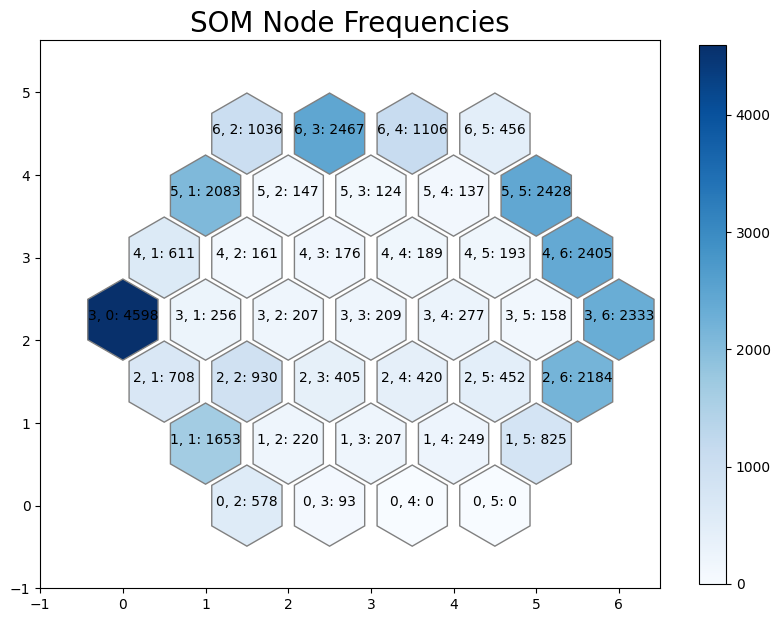

In [12]:
fig = hex_frequency_plot(hexsom, winmap)
plt.title('SOM Node Frequencies', fontsize=20)
plt.show()

(7, 7, 6771)
35


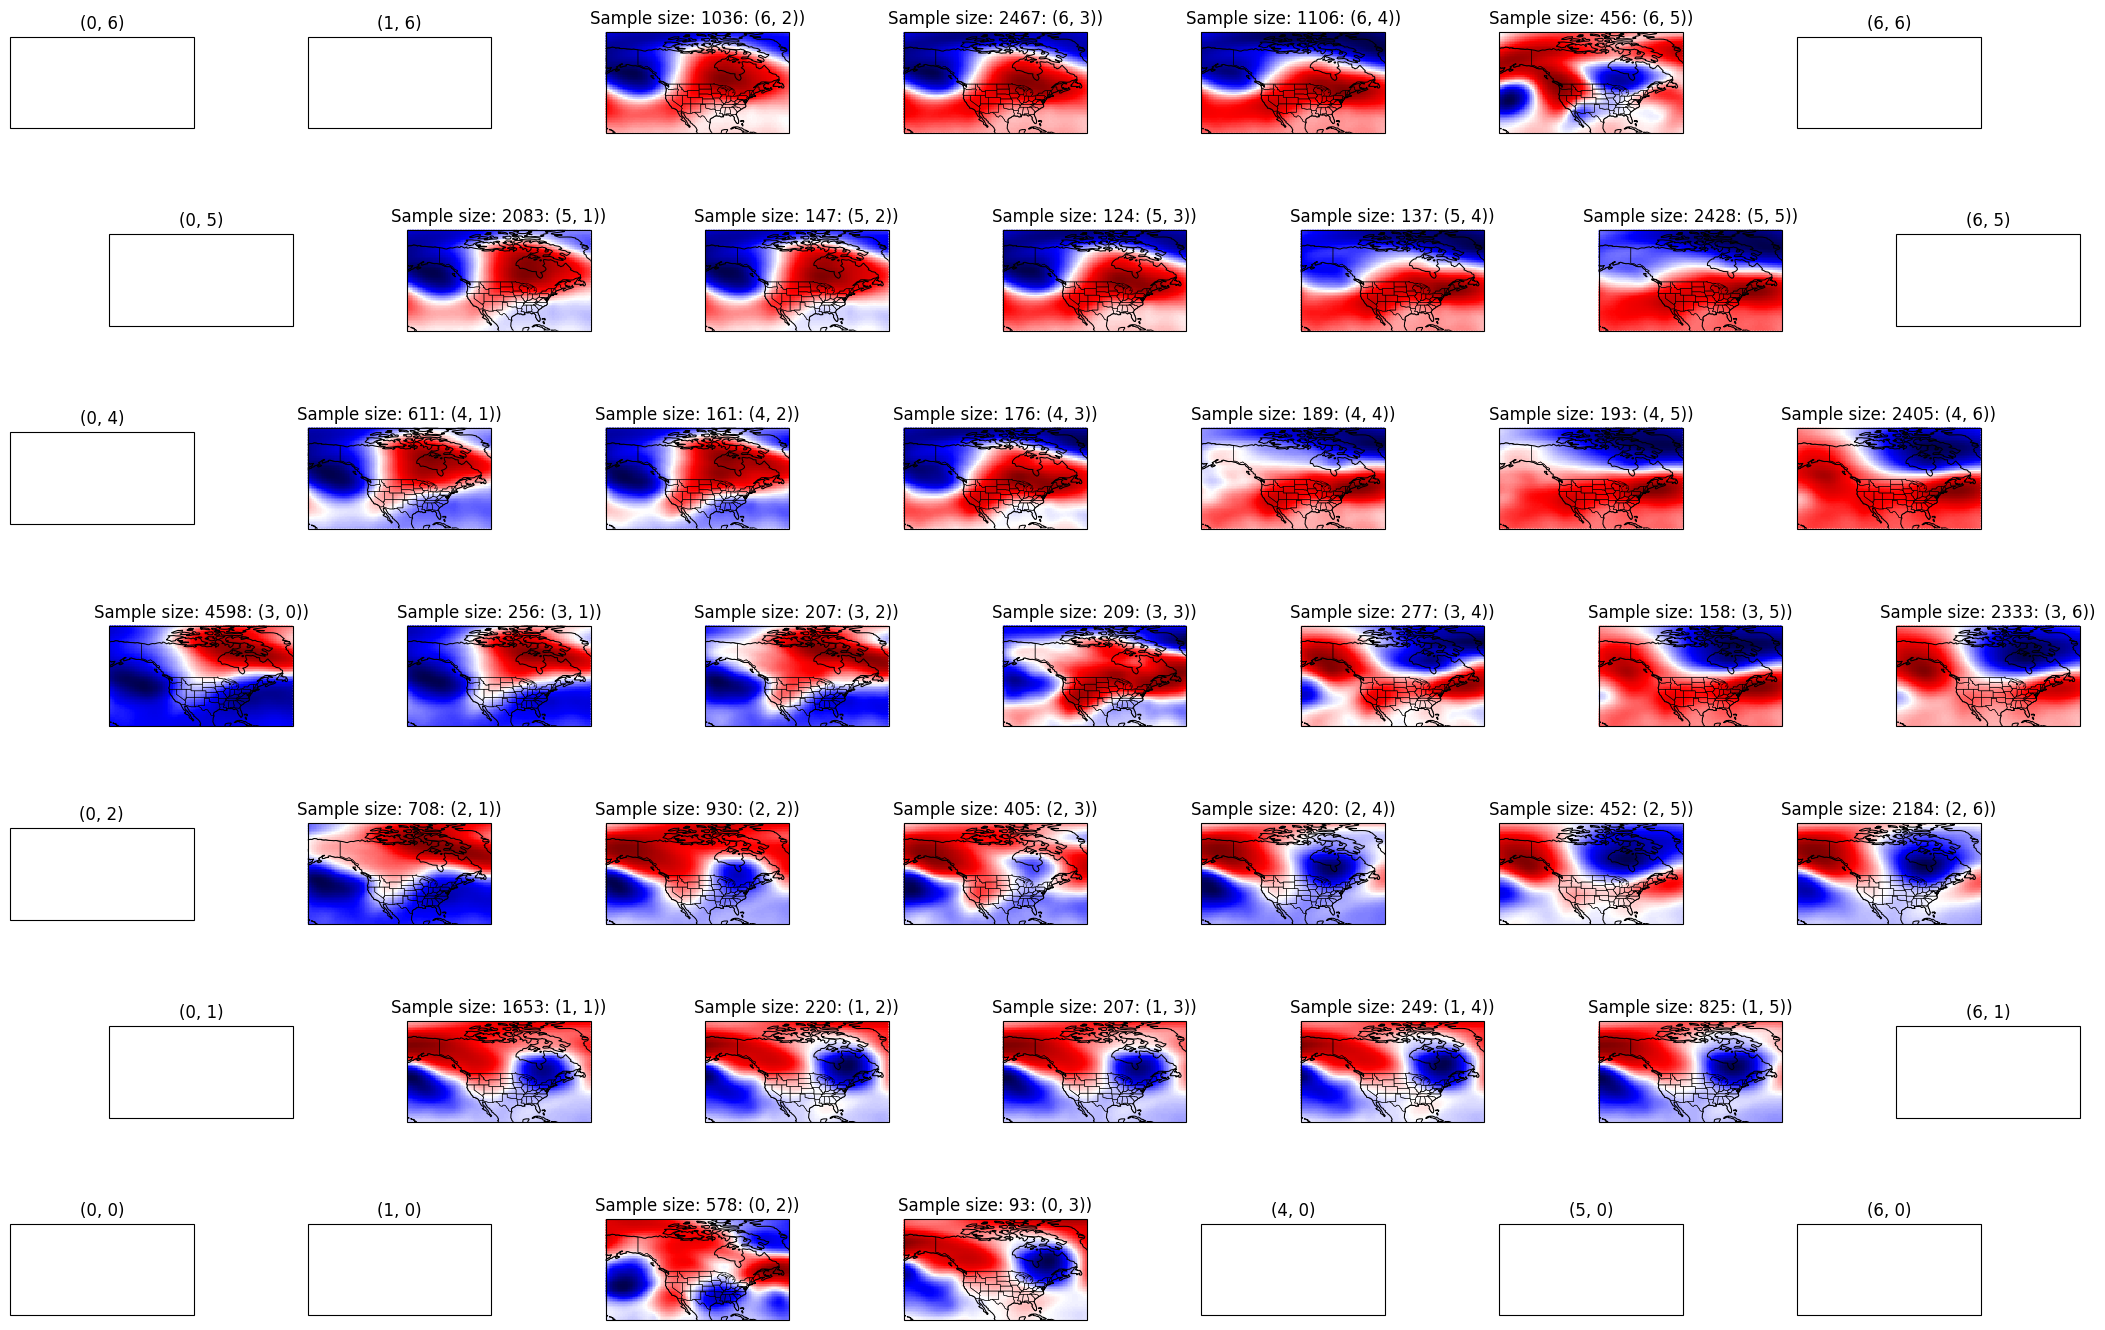

In [74]:
fig = hex_composite_map(hexsom, winmap)
fig.tight_layout()
plt.show()

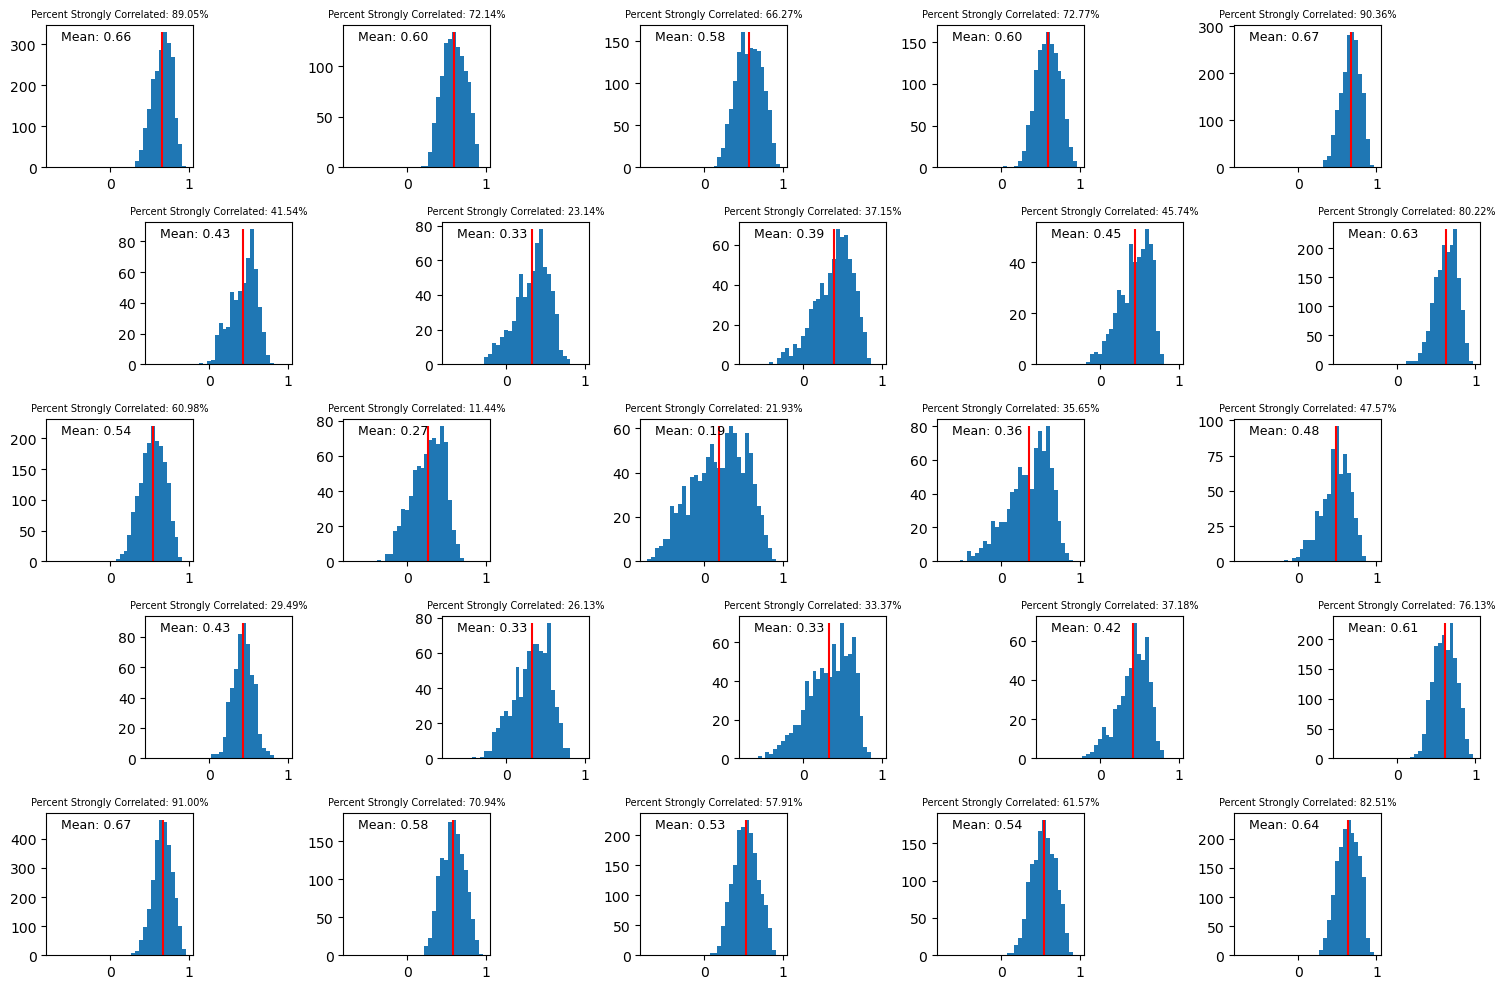

In [11]:
fig, axs = hex_plot(5, 5)

# min an max correlations for consistent axis
maxCorr = max(sum(somCorrelations.values(), []))
minCorr = min(sum(somCorrelations.values(), []))

for neuron in neurons:
    correlations = somCorrelations[neuron]
    ax = axs[neuron[0], neuron[1]]
    
    strongCorr = [c for c in correlations if c > .5]
    strongCorr = (len(strongCorr) / len(correlations)) * 100
    mean = np.mean(correlations)
    
    count, bins, _ = ax.hist(correlations, bins=np.arange(minCorr, 1, .05), range=(minCorr, maxCorr))
    ax.vlines(mean, 0, max(count), label='Mean', color='r')
    ax.text(0.1, 0.9, f'Mean: {mean:.2f}', fontsize=9, transform=ax.transAxes)
    ax.set_title(f'Percent Strongly Correlated: {strongCorr:.2f}%', fontsize=7)
    
fig.tight_layout()
plt.show()

In [12]:
# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in winmap:
    idxs = np.array(winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

# Caluculate the average persistence for each node
averagePersistences = {k: round(sum(v[0] * v[1]) / sum(v[1]), 2) for k, v in regimePersistences.items()}

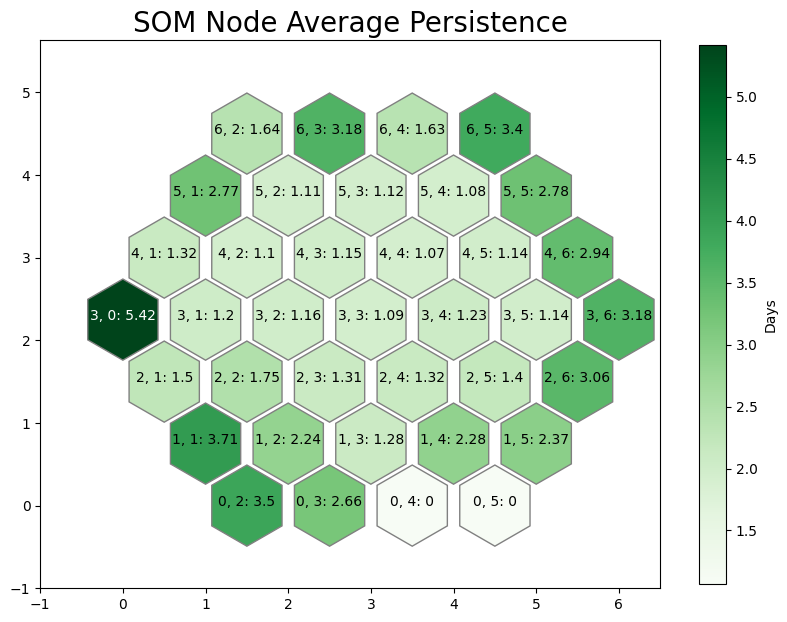

In [80]:
fig = hex_heatmap(hexsom, averagePersistences, 'Greens', 'SOM Node Average Persistence', 'Days')
plt.show()

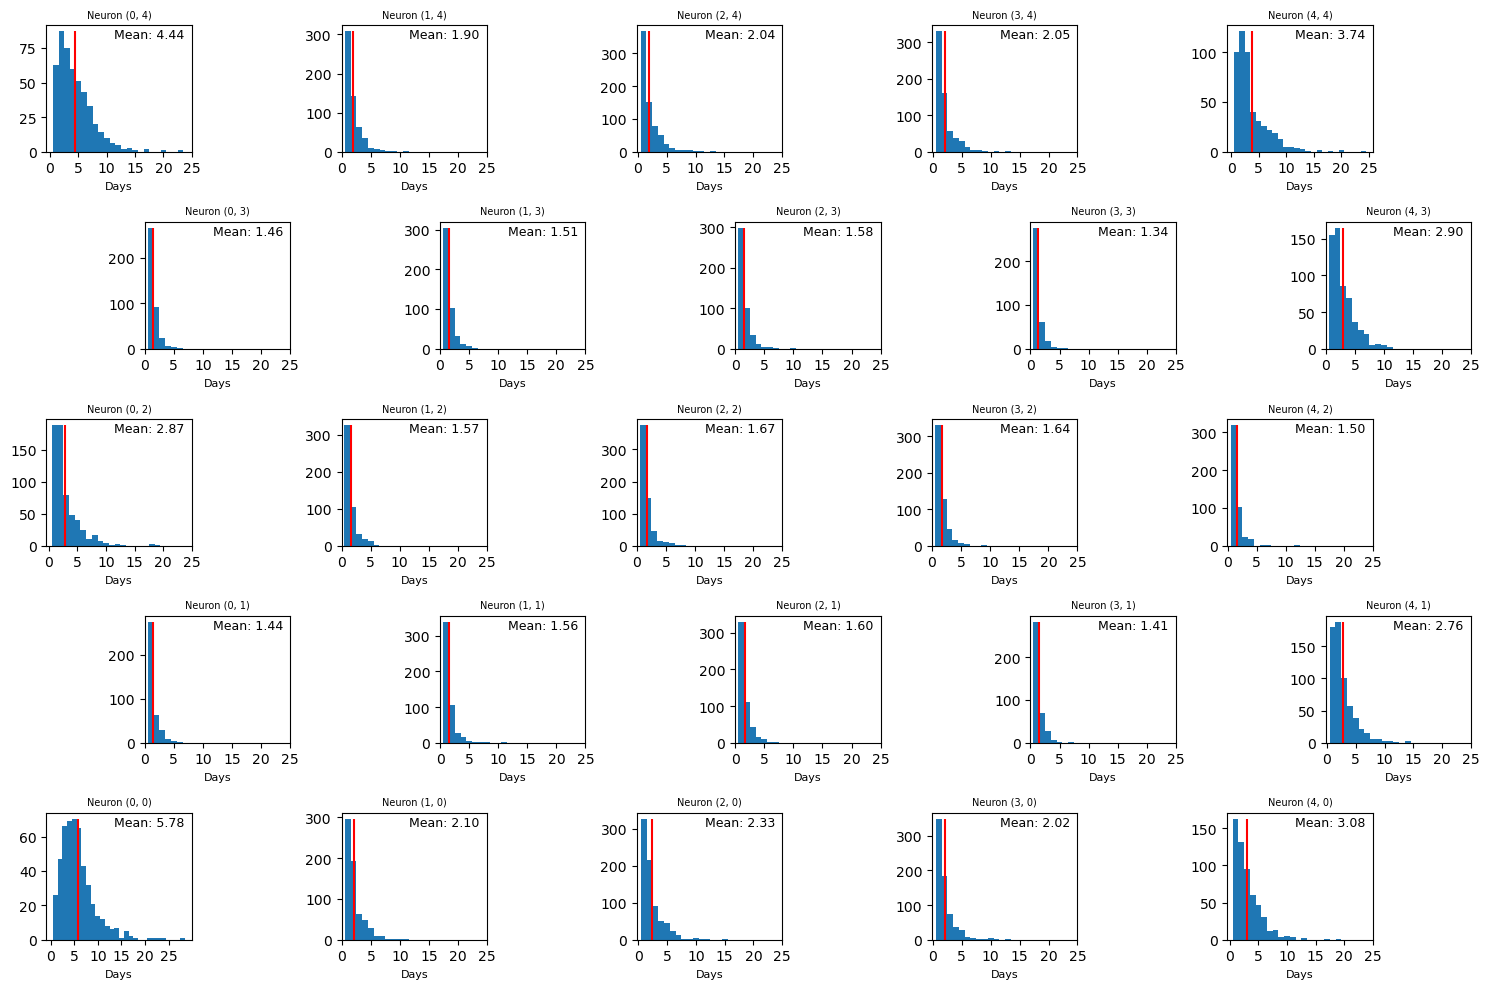

In [13]:
fig, axs = hex_plot(5, 5)

# Find the longest stretch of a consistant regime 
maxDays = max(regimePersistences.values(), key=lambda x: x[0][-1])[0][-1]

for neuron in neurons:
    ax = axs[neuron[0], neuron[1]]
    numDays, count = regimePersistences[neuron]
    
    mean = sum(numDays * count) / sum(count)

    ax.bar(numDays, count, width=1)
    ax.vlines(mean, 0, max(count), label='Mean', color='red')
    ax.text(.95, .9, f'Mean: {mean:.2f}', fontsize=9, 
            horizontalalignment='right', transform=ax.transAxes)
    ax.set_xlabel('Days', fontsize=8)
    ax.xaxis.set_ticks(np.arange(0, maxDays, 5))
    ax.set_title(f'Neuron {neuron}', fontsize=7)
    
fig.tight_layout()
plt.show()

In [14]:
# List of regimes for each day in order
neuronList = []
for i, x in enumerate(dataarray):
    neuronList.append(hexsom.winner(x))

# groups each continuous strech of a regime together
# COMMENT OUT THE LINE BELOW TO INCLUDE SELF TRANSITIONS
neuronList = [k for k, g in itertools.groupby(neuronList)]
# pairs up each value to get list of [first regime, next regime]
transitions = list(itertools.pairwise(neuronList))

# get the counts of each possible transition
transitions, tcounts = np.unique(transitions, return_counts=True, axis=0)

transitionProbs = {}
transitionCounts = {}
for i in range(len(neurons)):
    neuronIdxs = np.argwhere((
        transitions[:, 0, 0] == neurons[i][0]) & (transitions[:, 0, 1] == neurons[i][1]))
    
    transitionKeys = [tuple(l) for l in transitions[neuronIdxs, 1, :][:, 0, :]]
    transitionCnt = list(tcounts[neuronIdxs][:, 0])
    probabilities = list((tcounts[neuronIdxs] / sum(tcounts[neuronIdxs]))[:, 0])
    transitionProbs[neurons[i]] = dict(zip(transitionKeys, probabilities))
    transitionCounts[neurons[i]] = dict(zip(transitionKeys, transitionCnt))


In [15]:
def temp(som, data, ax=None):
    # set up the figure
    if ax == None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
    
    ax.set_aspect('equal')
        

    # get the coordinates for the hexes
    weights = hexsom.get_weights()
    xx, yy = som.get_euclidean_coordinates()
    maxData = max(data.values())
    
    for x, y in list(product(range(weights.shape[0]), range(weights.shape[0]))):
        if (x, y) in data:
            # determine the color for the hexagon
            colorWeight = data[(x, y)]/maxData
            color = colormaps['Blues'](colorWeight)
            text = float(data[(x, y)])
            
        else:
            # if no daa plot it white
            color = 'white'
            text = 0.0
            
        # determine the hexagon position and color
        wy = yy[(x, y)] * np.sqrt(3) / 2
        
        # Create hexagon and add it to axis
        hex = patches.RegularPolygon((xx[(x, y)], wy), numVertices=6, radius=.85 / np.sqrt(3), 
                                    facecolor=color, edgecolor='grey')
        ax.add_patch(hex)
        
        # add text to hexagon for its frequency
        ax.text(xx[(x, y)], wy, f'{int(text)}', {'horizontalalignment': 'center'}, fontsize=5)

        
    # align figure to show all hexagons
    ax.set_xlim(-1, weights.shape[0] - .5)
    ax.set_ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)
    ax.set_xticks([])
    ax.set_yticks([])
    #plt.title('Hexagon SOM Frequencies')

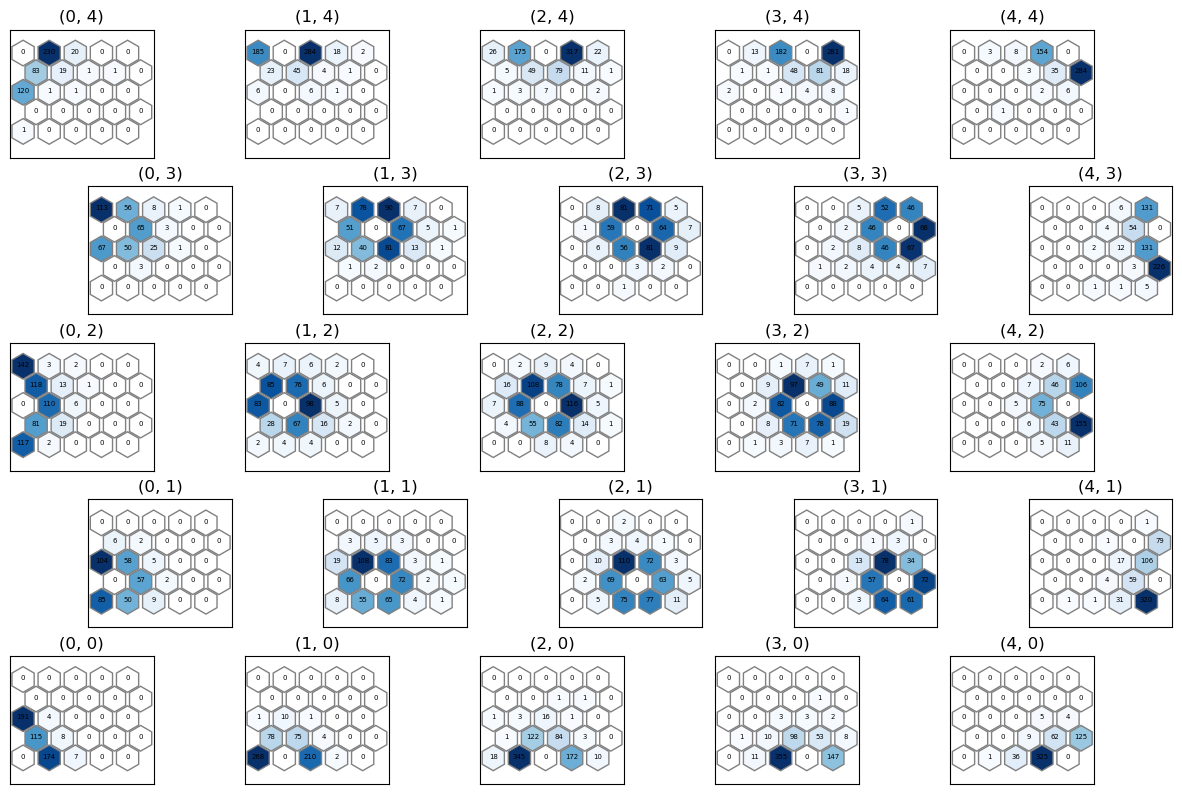

In [16]:
fig, axs = hex_plot(5, 5)

for neuron in neurons:
    ax = axs[neuron[0], neuron[1]]
    temp(hexsom, transitionCounts[neuron], ax)

In [17]:
color_list = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231", 
    "#911eb4", "#42d4f4", "#f032e6", "#bfef45", "#fabed4", 
    "#469990", "#dcbeff", "#9a6324", "#fffac8", "#800000", 
    "#aaffc3", "#808000", "#ffd8b1", "#000075", "#a9a9a9",
    "#00ffff", "#ff0000", "#00ff00", "#0000ff", "#ff00ff"
]
color_list = [
    "red", "green", "blue", "yellow", "orange", "purple", "pink", "brown", "gray", 
    "cyan", "magenta", "lime", "teal", "navy", "maroon", "olive", "lavender", "turquoise",
    "gold", "silver", "salmon", "plum", "indigo", "tan", "darkgreen"
]


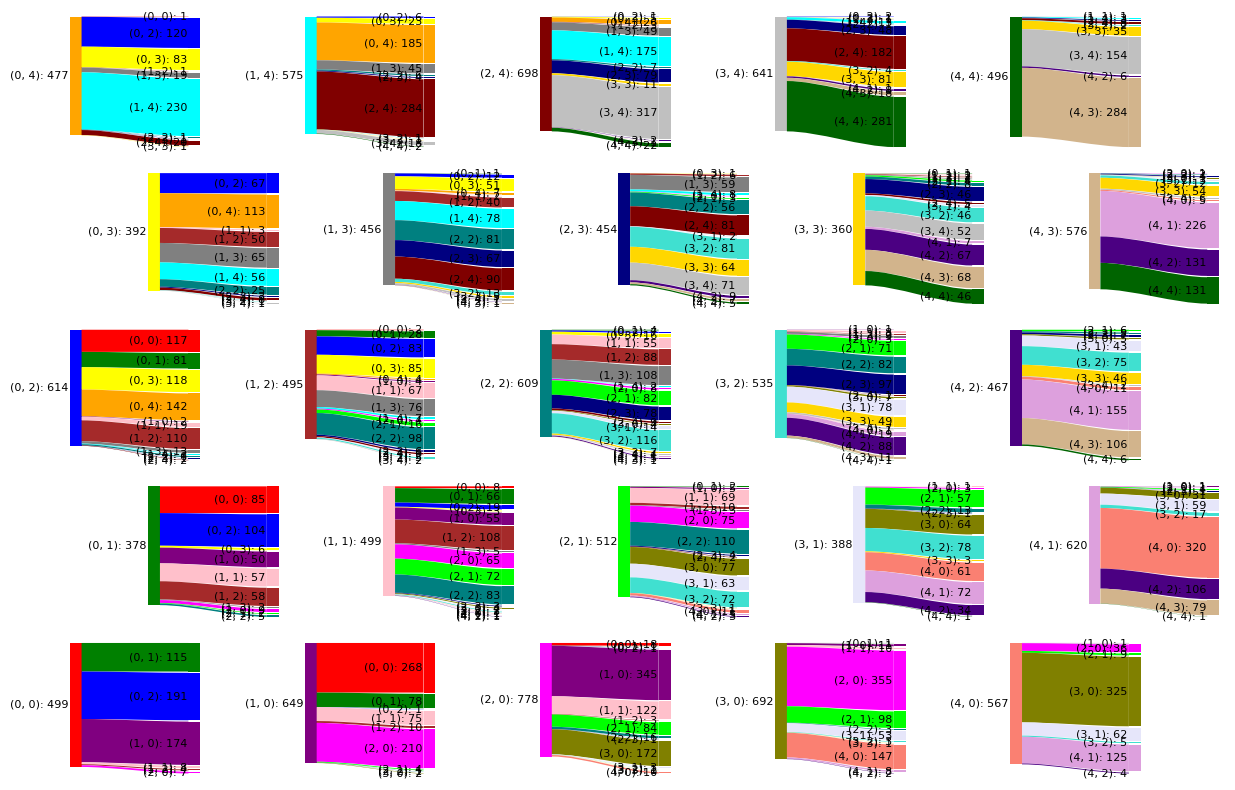

In [18]:
 # create plot
fig, axs = hex_plot(5, 5)

for neuron in neurons:
    # set the current axis
    ax = axs[neuron[0], neuron[1]]
    ax.set_title('')
    plt.sca(ax)
    
    # Get the transitions for the current node
    trans = transitionCounts[neuron]
    tot = sum(trans.values())
    # Limit the number of small flows
    trans = [i for i in trans.items() if i[1] >= 0]
    
    # Start node will be the current node
    nodes = [[(str(neuron), tot, {'color':color_list[(neuron[0]*5) + neuron[1]]})]]
    # Add all of the nodes that are transitioned to
    nodes.append([((str(n)), cnt, {'color':color_list[(n[0]*5)+n[1]]}) for n, cnt in trans])
    # Create the flows
    flows = [(str(neuron), str(target), cnt) for target, cnt in trans]
    s = Sankey(nodes=nodes, flows=flows, node_width=.1, flow_color_mode_alpha=1, 
               node_opts=dict(label_format='{label}: {value}', label_opts=dict(fontsize=8)))
    s.draw()
    
plt.show()

In [27]:
hexsom._activation_distance(dataarray[100], hexsom._weights)

array([[46.59569031, 50.13012266, 56.47699461, 64.52012236, 71.18384257],
       [48.41913802, 53.0212621 , 56.99879004, 65.12269465, 70.44106697],
       [53.78528042, 59.47892022, 60.47472414, 68.8344711 , 71.6201053 ],
       [61.86754582, 67.2178395 , 66.85785533, 74.27471524, 75.4778564 ],
       [69.1356344 , 73.12759141, 73.15124808, 78.58289187, 79.58805739]])